# 2026-01-12 Finite Differences

## Last time
* General shape of PDE solvers and stakeholders
* Comparing/plotting cost and accuracy
* Learning strategy

## Today
* Discussion and scoping
* Evaluating derivatives
* Taylor series and truncation error
* Stability
* Measuring convergence

## Examples of PDE

* Navier-Stokes (viscous fluids)
  * nonlinear
  * incompressible or compressible
* Elasticity
  * linear elasticity
  * hyperelasticity (geometric nonlinear + material nonlinearity)
  * time dependent (dynamics) or steady state
* Hamilton-Jacobi-Bellman
  * optimal control
* Wave equations
  * acoustics
  * elasticity
  * electromagnetics
  * frequency domain

# Choices in scoping the class

## Theory

Analysis first, confirm using numerics.
Limited to simpler models.

## Applied
Numerics first, pointers to useful theory.

---

## Build from scratch

Limited to simpler models, but you'll understand everything under the hood.

## Build using libraries

More installation and software layers, but can solve more interesting problems.

# Consider the boundary value problem: find $u$:

\begin{gather} -\frac{d^2 u}{dx^2} = f(x) \quad x \in \Omega = (-1,1) \\
u(-1) = a \quad \frac{du}{dx}(1) = b .
\end{gather}

We say
* $f(x)$ is the "forcing"
* the left boundary condition is Dirichlet
* the right boundary condition is Neumann

We need to choose
* how to represent $u(x)$, including evaluating it on the boundary,
* how to compute derivatives of $u$,
* in what sense to ask for the differential equation to be satisfied,
* where to evaluate $f(x)$ or integrals thereof,
* how to enforce boundary conditions.

# Finite Difference/collocation approach to solve $u$:

\begin{gather} -\frac{d^2 u}{dx^2} = f(x) \quad x \in \Omega = (-1,1) \\
u(-1) = a \quad \frac{du}{dx}(1) = b .
\end{gather}

* Represent the function $u(x)$ by its values $u_i = u(x_i)$ at a discrete set of points $$ -1 = x_1 < x_2 < \dotsb < x_n = 1 . $$
  * The FD framework does not uniquely specify the solution values at other points
* Compute derivatives at $x_i$ via differencing formulas involving a finite number of neighbor points (independent of the total number of points $n$).
* FD methods ask for the differential equation to be satisfied pointwise at each $x_i$ in the interior of the domain.
* Evaluate the forcing term $f$ pointwise at $x_i$.
* Approximate derivatives at discrete boundary points ($x_n = 1$ above), typically using one-sided differencing formulas.

# Computing a derivative

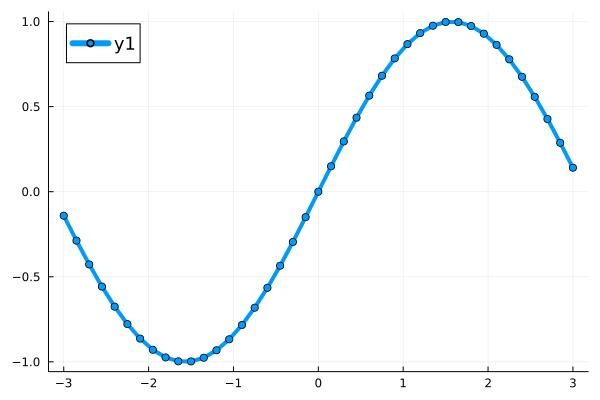

In [1]:
using Plots
default(linewidth=4, legendfontsize=12)

n = 41
h = 6 / (n - 1)
x = LinRange(-3, 3, n)
u = sin.(x)
plot(x, u, marker=:circle)

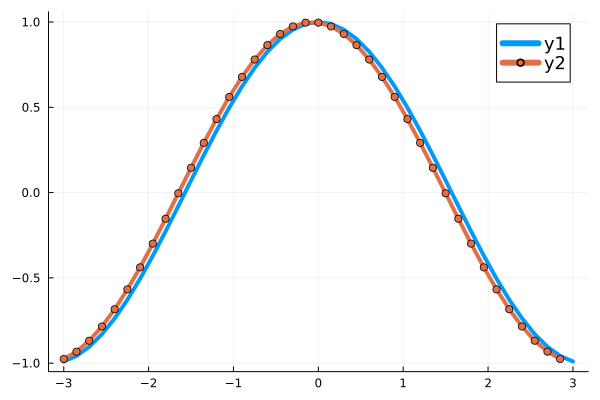

In [2]:
u_x = cos.(x)
fd_u_x = (u[2:end] - u[1:end-1]) / h

plot(x, u_x)
plot!(x[1:end-1], fd_u_x, marker=:circle)

# How accurate is it?

Without loss of generality, we'll approximate $u'(x_i = 0)$, taking $h = x_{i+1} - x_i$.

$$ u(x) = u(0) + u'(0)x + u''(0)x^2/2! + O(x^3)$$
and substitute into the differencing formula
$$ \begin{split} u'(0) \approx \frac{u(h) - u(0)}{h} = h^{-1} \Big( u(0) + u'(0) h + u''(0)h^2/2 + O(h^3) - u(0) \Big) \\
= u'(0) + u''(0)h/2 + O(h^2) . \end{split}$$
Evidently the error in this approximation is $u''(0)h/2 + O(h^2)$. We say this method is *first order accurate*.

# A note on stable computation

In [3]:
x = big(1e-15)
@show big(1+x)
@show log(1 + x)

big(1 + x) = 1.000000000000001000000000000000077705399876661079238307185601195015145492561714
log(1 + x) = 9.999999999999995777053998766613348662406422732737965069319591605458493216045864e-16


9.999999999999995777053998766613348662406422732737965069319591605458493216045864e-16

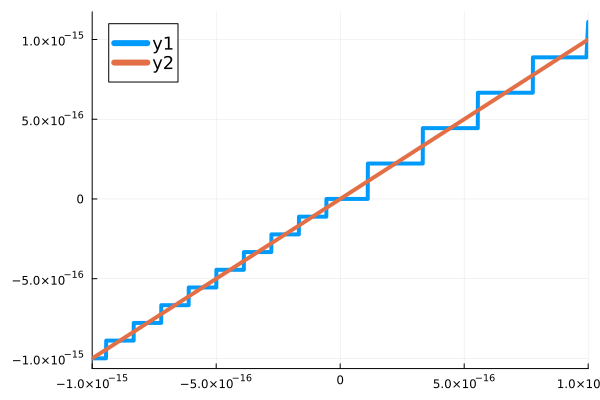

In [4]:
plot([h -> log(1+h), log1p], xlim=(-1e-15, 1e-15))

What happens as we zoom in?

# A few methods on grids

In [5]:
diff1l(x, u) = x[2:end],   (u[2:end] - u[1:end-1]) ./ (x[2:end] - x[1:end-1])
diff1r(x, u) = x[1:end-1], (u[2:end] - u[1:end-1]) ./ (x[2:end] - x[1:end-1])
diff1c(x, u) = x[2:end-1], (u[3:end] - u[1:end-2]) ./ (x[3:end] - x[1:end-2])
difflist = [diff1l, diff1r, diff1c]

n = 40 
h = 2 / (n - 1)
x = LinRange(-3, 3, n)
u = sin.(x)
fig = plot(cos, xlims=(-3, 3))
for d in difflist
    xx, yy = d(x, u)
    plot!(fig, xx, yy, marker=:circle, label=d)
end

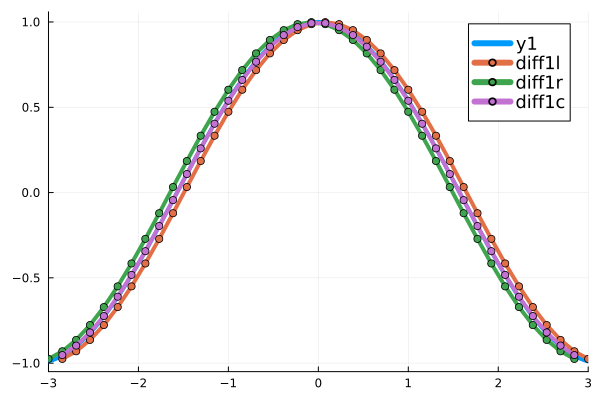

In [6]:
fig

# Measuring error on grids

In [7]:
using LinearAlgebra
default(legendfontsize=12)

grids = 2 .^ (2:10)
hs = 1 ./ grids
function refinement_error(f, fprime, d)
    error = []
    for n in grids
        x = LinRange(-3, 3, n)
        xx, yy = d(x, f.(x))
        push!(error, norm(yy - fprime.(xx), 2)/sqrt(n))
    end
    error
end

refinement_error (generic function with 1 method)

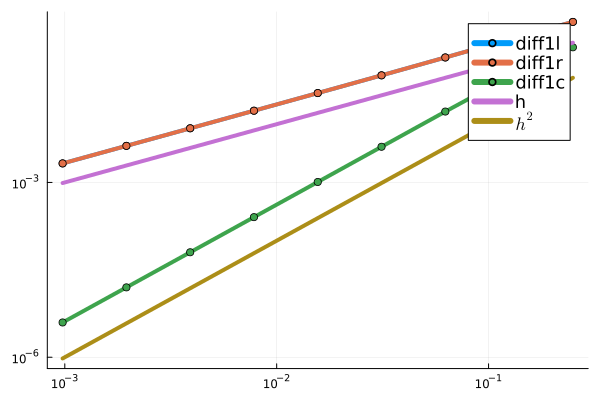

In [8]:
fig = plot(xscale=:log10, yscale=:log10)
for d in difflist
    error = refinement_error(sin, cos, d)
    plot!(fig, hs, error, marker=:circle, label=d)
end
plot!(fig, hs, [hs hs .^ 2], label=["h" "\$h^2\$"])

What happens if we use a 1-norm or 2-norm?

# Stability

Are there "rough" functions for which these formulas estimate $u'(x_i) = 0$?

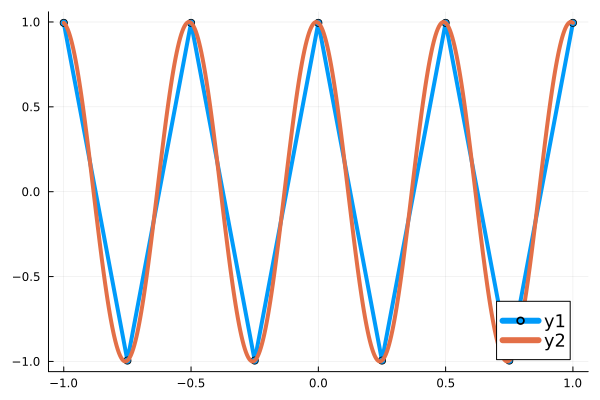

In [9]:
x = LinRange(-1, 1, 9)
f_rough(x) = cos(.1 + 4π*x)
fp_rough(x) = -4π*sin(.1 + 4π*x)

plot(x, f_rough, marker=:circle)
plot!(f_rough)

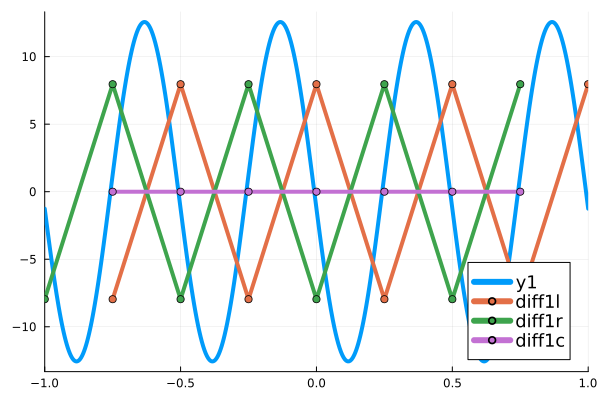

In [10]:
fig = plot(fp_rough, xlims=(-1, 1))
for d in difflist
    xx, yy = d(x, f_rough.(x))
    plot!(fig, xx, yy, label=d, marker=:circle)
end
fig

If we have a solution $u(x)$, then $u(x) + f_{\text{rough}}(x)$ is indistinguishable to our FD method.

# Consistency + Stability = Convergence

## [Lax Equivalence Theorem]

## Consistency

* When we apply the differential operator to the exact solution, we get a small residual.
* The residual converges under grid refinement.
* Hopefully fast as $h \to 0$

## Stability

* There do not exist "bad" functions that also satisfy the equation.
* The solution does not "blow up" for time-dependent problems.
* Definition here is intentionally vague, and there are more subtle requirements for problems like incompressible flow.




# Second derivatives

We can compute a second derivative by applying first derivatives twice.

In [11]:
function diff2a(x, u)
    xx, yy = diff1c(x, u)
    diff1c(xx, yy)
end

function diff2b(x, u)
    xx, yy = diff1l(x, u)
    diff1r(xx, yy)
end

diff2list = [diff2a, diff2b]
n = 20
x = LinRange(-3, 3, n)
u = - cos.(x);

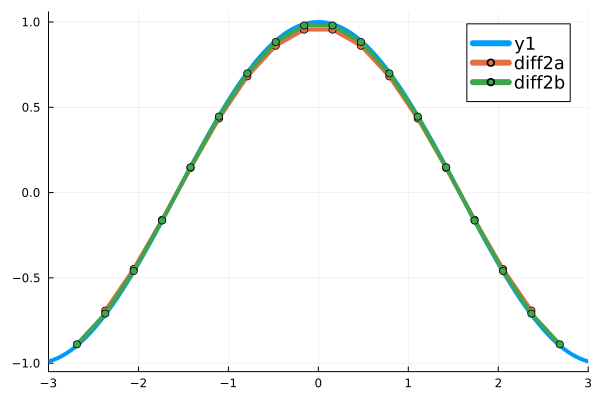

In [12]:
fig = plot(cos, xlims=(-3, 3))
for d2 in diff2list
    xx, yy = d2(x, u)
    plot!(fig, xx, yy, marker=:circle, label=d2)
end
fig

# How fast do these approximations converge?

In [13]:
grids = 2 .^ (3:10)
hs = 1 ./ grids
function refinement_error2(f, f_xx, d2)
    error = []
    for n in grids
        x = LinRange(-3, 3, n)
        xx, yy = d2(x, f.(x))
        push!(error, norm(yy - f_xx.(xx), Inf
        )) # which norm?
    end
    error
end

refinement_error2 (generic function with 1 method)

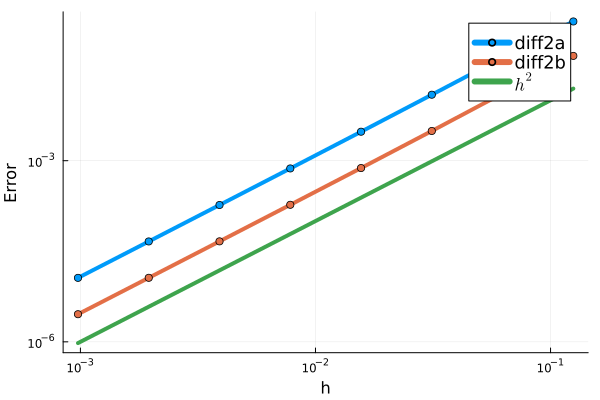

In [14]:
fig = plot(xlabel="h", xscale=:log10, ylabel="Error", yscale=:log10)
for d2 in diff2list
    error = refinement_error2(x -> -cos(x), cos, d2)
    plot!(fig, hs, error, marker=:circle, label=d2)
end
plot!(fig, hs, hs .^ 2, label="\$h^2\$") 

* Both methods are second order accurate.
* The `diff2b` method is more accurate than `diff2a` (by a factor of 4)
* The `diff2a` method can't compute derivatives at points adjacent the boundary.
* We don't know yet whether either is stable

# Differentiation matrices

All our `diff*` functions thus far have been linear in `u`, therefore they can be represented as matrices.
$$\frac{u_{i+1} - u_i}{x_{i+1} - x_i} = \begin{bmatrix} -1/h & 1/h \end{bmatrix} \begin{bmatrix} u_i \\ u_{i+1} \end{bmatrix}$$

In [15]:
function diff1_mat(x)
    n = length(x)
    D = zeros(n, n)
    h = x[2] - x[1]
    D[1, 1:2] = [-1/h  1/h]
    for i in 2:n-1
        D[i, i-1:i+1] = [-1/2h  0  1/2h]
    end
    D[n, n-1:n] = [-1/h  1/h]
    D
end
x = LinRange(-1, 1, 5)
diff1_mat(x)

5×5 Matrix{Float64}:
 -2.0   2.0   0.0   0.0  0.0
 -1.0   0.0   1.0   0.0  0.0
  0.0  -1.0   0.0   1.0  0.0
  0.0   0.0  -1.0   0.0  1.0
  0.0   0.0   0.0  -2.0  2.0

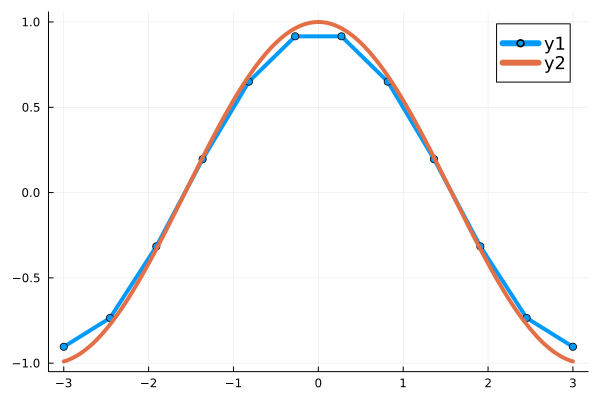

In [16]:
n = 12
x = LinRange(-3, 3, n)
plot(x, diff1_mat(x) * sin.(x), marker=:circle)
plot!(cos)

# How accurate is this derivative matrix?

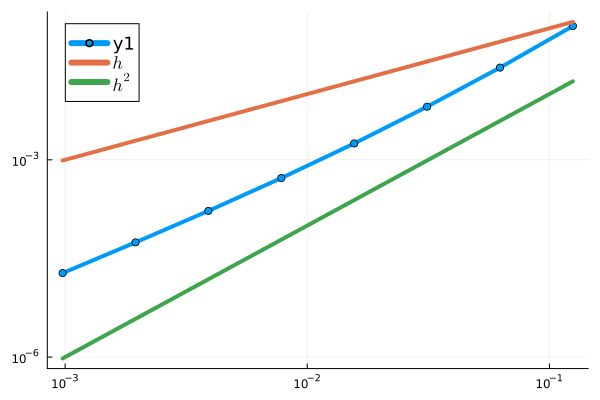

In [17]:
fig = plot(xscale=:log10, yscale=:log10, legend=:topleft)
error = refinement_error(sin, cos, (x, u) -> (x, diff1_mat(x) * u))
plot!(fig, hs, error, marker=:circle)
plot!(fig, hs, hs, label="\$h\$")
plot!(fig, hs, hs .^ 2, label="\$h^2\$")

# Can we study it as a matrix?

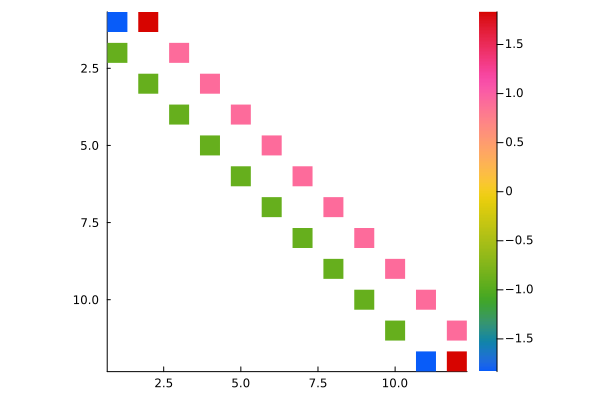

In [18]:
function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

D = diff1_mat(x)
my_spy(D)

In [19]:
svdvals(D)

12-element Vector{Float64}:
 2.7718000318790152
 2.7716788692501084
 1.7708640148632901
 1.732003875931066
 1.5877132402714698
 1.4519108222799693
 1.2963624321753364
 1.0397961559479483
 0.9166666666666657
 0.5413728320040285
 0.4745015826879543
 1.7546012240164312e-16

# Second derivative with Dirichlet boundary conditions

The left endpoint in our example boundary value problem has a Dirichlet boundary condition,
$$u(-1) = a . $$
With finite difference methods, we have an explicit degree of freedom $u_1 = u(x_1 = -1)$ at that endpoint.
When building a matrix system for the BVP, we can implement this boundary condition by modifying the first row of the matrix,
$$ \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ \\ & & A_{2:,:} & & \\ \\ \end{bmatrix} \begin{bmatrix} u_1 \\ \\ u_{2:} \\ \\ \end{bmatrix} = \begin{bmatrix} a \\ \\ f_{2:} \\ \\ \end{bmatrix} . $$

* This matrix is not symmetric even if $A$ is.

In [20]:
function laplacian_dirichlet(x)
    n = length(x)
    D = zeros(n, n)
    h = x[2] - x[1]
    D[1, 1] = 1
    for i in 2:n-1
        D[i, i-1:i+1] = (1/h^2) * [-1, 2, -1]
    end
    D[n, n] = 1
    D
end

laplacian_dirichlet (generic function with 1 method)

# Laplacian as a matrix

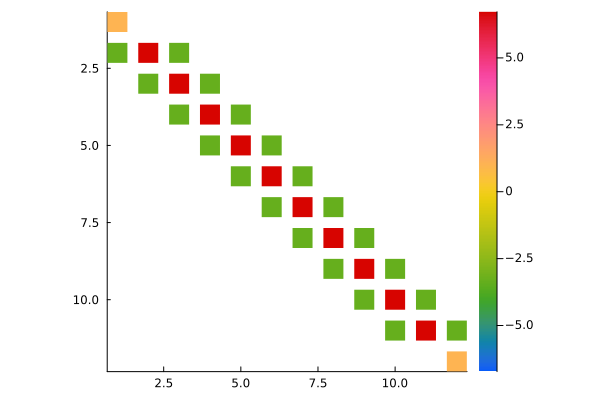

In [21]:
L = laplacian_dirichlet(x)
my_spy(L)

In [22]:
cond(L)

56.42029373680045

# Solutions

$$ \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ \\ & & A_{2:n-1,:} & & \\ \\ \\ 0&0 &0 &0 &0 & 1 \end{bmatrix} \begin{bmatrix} u_1 \\ \\ u_{2:} \\ \\ \\ u_n \end{bmatrix} = \begin{bmatrix} a \\ \\ f_{2:} \\ \\ \\ b \end{bmatrix} . $$

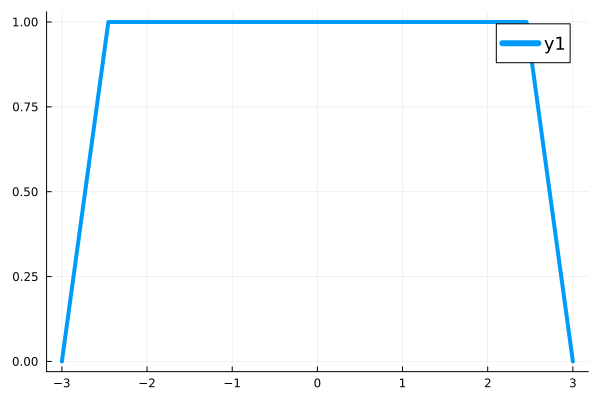

In [23]:
L = laplacian_dirichlet(x)
f = one.(x)
f[1] = 0
f[end] = 0;
plot(x, f)

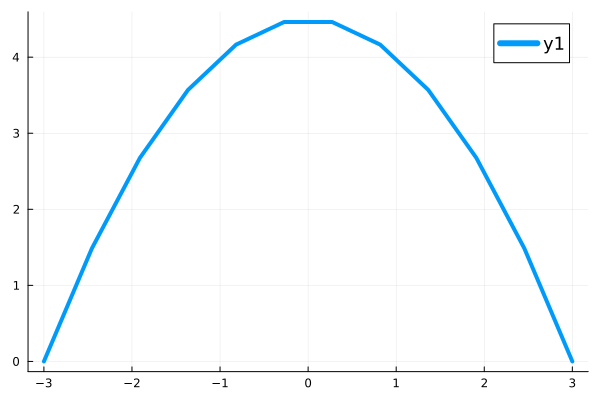

In [24]:
u = L \ f
plot(x, u)

# Activity on stability and accuracy computing derivatives

* Accept the activity on Canvas
* Clone the repo
  * If you're using coding.csel.io
    * use `gh auth login` from the terminal (you'll only need to do this once)
    * then use the Git sidebar widget to clone
  * `git clone https://github.com/cu-numpde/2026-01-12-derivatives-YOUR-GH-USERNAME` (or with `ssh`)
* Complete the activity, commit your changes, and push.